<a href="https://colab.research.google.com/github/yiwang099/Adult-dataset-scikit-learn-project/blob/main/PracticeProjectPart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Read the records from the file
records = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

# Training and testing the set, remove the records contain unknown values
train = pd.read_csv('adult.data', sep = r',\s*', header = None, names = records, engine = 'python', na_values="?")
test = pd.read_csv('adult.test', sep = r',\s*', header = None, names = records, engine = 'python', skiprows = 1, na_values="?")
#test['income'] = test['income'].str.strip()
test['income'] = test['income'].str.replace(r'\.', '', regex=True)# Get away the period in the file
train = train.dropna()
test = test.dropna()

# Remove all continuous attributes, which: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week
contAttr = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
train = train.drop(columns = contAttr)
test = test.drop(columns = contAttr)
#print(train.head())
#print(test.head())

# One-hot Encoding

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
# Use one-hot encoding to transform data
# Separate income from other attributes, because we will use income as the main attribute to distinguish the dataset
X_train = train.drop('income', axis=1)
y_train = train['income']

X_test = test.drop('income', axis=1)
y_test = test['income']
X_test_encoded = pd.get_dummies(X_test, drop_first=False)
#print("Data after encoded:") # For testing
#print(train_encoded.shape)

categorical_cols = X_train.select_dtypes(include=['object']).columns
#print("Categorical columns:", categorical_cols)

# Create and fit OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Transformation
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]), index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]), index=X_test.index)

to_concat_train = [df for df in [X_train.drop(columns=categorical_cols), X_train_encoded] if not df.empty]
to_concat_test  = [df for df in [X_test.drop(columns=categorical_cols), X_test_encoded] if not df.empty]

X_train_final = pd.concat(to_concat_train, axis=1)
X_test_final  = pd.concat(to_concat_test, axis=1)

# Decision Tree Classifier

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Create the model for decision tree classifier
dt = DecisionTreeClassifier(random_state = 0)

# Train the model
dt.fit(X_train_final, y_train)

# Let the model makes prediction
y_pred_dt = dt.predict(X_test_final)

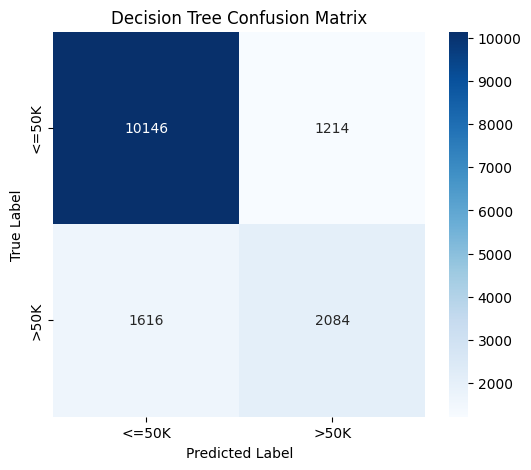

For <=50K:
Decision Tree Report:
TP rate (Recall): 89.31%
FP rate: 43.68%
Precision: 86.26%
Recall: 89.31%
F1 Score: 87.76%


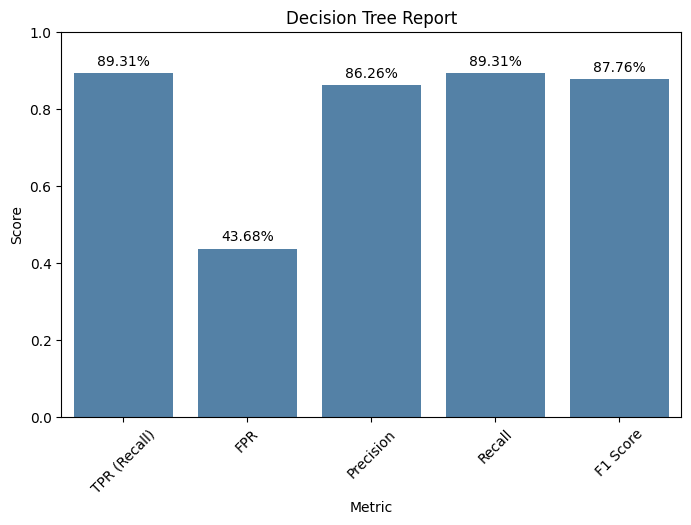

For >50K:
Decision Tree Report:
TP rate (Recall): 56.32%
FP rate: 10.69%
Precision: 63.19%
Recall: 56.32%
F1 Score: 59.56%


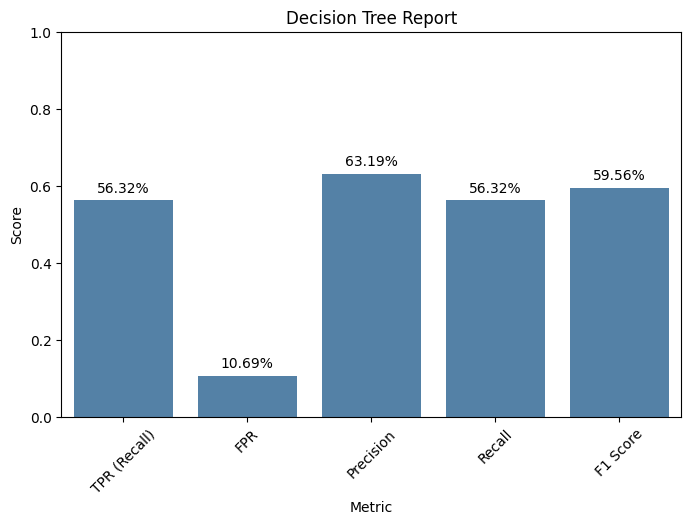

In [15]:
# Report accuracy by class including (TP rate, FP rate, precision, recall, F1)
# Confusion Matrix: [[TN, FP],
#            [FN, TP]]
DTcm = confusion_matrix(y_test, y_pred_dt, labels=['<=50K', '>50K'])
# Draw the confusion matrix out
plt.figure(figsize=(6,5))
sns.heatmap(DTcm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Calculation indicators
def DTreport(TP, FP, FN, TN):
  TPrate = TP / (TP + FN)
  FPrate = FP / (FP + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)  # same as TPrate
  F1 = 2 * precision * recall / (precision + recall)

  # Print the report
  print("Decision Tree Report:")
  print(f"TP rate (Recall): {TPrate*100:.2f}%")
  print(f"FP rate: {FPrate*100:.2f}%")
  print(f"Precision: {precision*100:.2f}%")
  print(f"Recall: {recall*100:.2f}%")
  print(f"F1 Score: {F1*100:.2f}%")

  # Visualize the report as a graph
  metrics = {
      'TPR (Recall)': TPrate,
      'FPR': FPrate,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': F1
  }

  metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
  plt.figure(figsize=(8,5))
  sns.barplot(x='Metric', y='Value', data=metrics_df, color='steelblue')

  plt.ylim(0, 1)
  plt.ylabel('Score')
  plt.title('Decision Tree Report')
  plt.xticks(rotation=45)
  for index, row in metrics_df.iterrows():
      plt.text(index, row['Value'] + 0.02, f"{row['Value']*100:.2f}%", ha='center')
  plt.show()

# Accuracy analysis for ">50k" and "<=50k" respectively
# For "<= 50k"：
TP_le = DTcm[0,0]
FN_le = DTcm[0,1]
FP_le = DTcm[1,0]
TN_le = DTcm[1,1]
print("For <=50K:")
reportLe = DTreport(TP_le, FP_le, FN_le, TN_le)

# For ">50K"：
TP_gt = DTcm[1,1]
FN_gt = DTcm[1,0]
FP_gt = DTcm[0,1]
TN_gt = DTcm[0,0]
print("For >50K:")
reportGt = DTreport(TP_gt, FP_gt, FN_gt, TN_gt)

# Naive Bayesian Classifier

In [12]:
from sklearn.naive_bayes import GaussianNB

In [16]:
# Create the model for Naive Bayesian classifier
nb = GaussianNB()

# Train the model
nb.fit(X_train_final, y_train)

# Let the model make prediction
y_pred_nb = nb.predict(X_test_final)

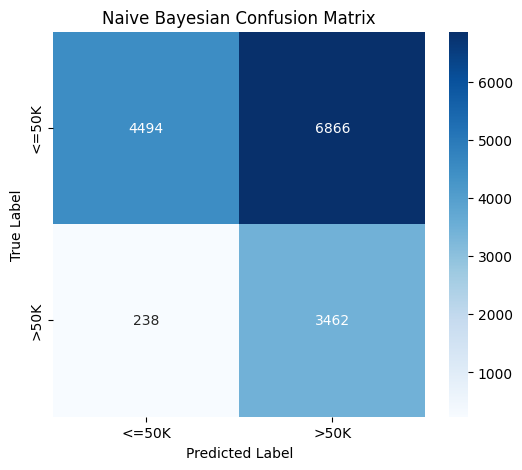

For <=50K:
TP rate (Recall): 39.56%
FP rate: 6.43%
Precision: 94.97%
Recall: 39.56%
F1 Score: 55.85%


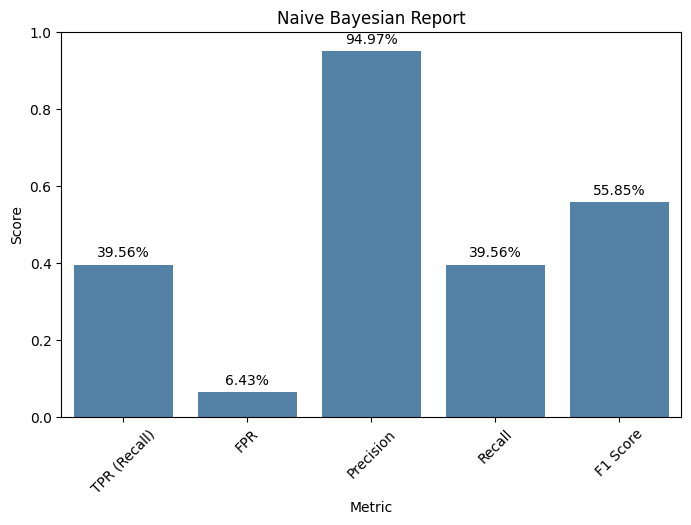

For >50K:
TP rate (Recall): 93.57%
FP rate: 60.44%
Precision: 33.52%
Recall: 93.57%
F1 Score: 49.36%


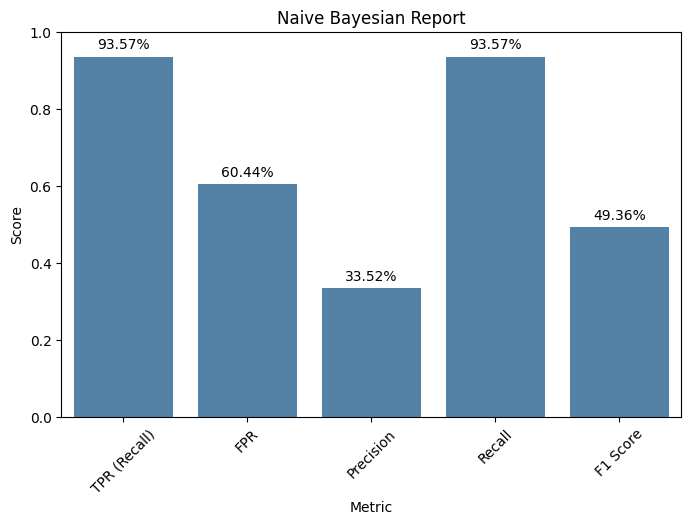

In [17]:
NBcm = confusion_matrix(y_test, y_pred_nb, labels=['<=50K', '>50K'])

plt.figure(figsize=(6,5))
sns.heatmap(NBcm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayesian Confusion Matrix')
plt.show()

def NBreport(TP, FP, FN, TN):
  TPrate = TP / (TP + FN)
  FPrate = FP / (FP + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F1 = 2 * precision * recall / (precision + recall)

  # Report accuracy by class including (TP rate, FP rate, precision, recall, F1)
  print(f"TP rate (Recall): {TPrate*100:.2f}%")
  print(f"FP rate: {FPrate*100:.2f}%")
  print(f"Precision: {precision*100:.2f}%")
  print(f"Recall: {recall*100:.2f}%")
  print(f"F1 Score: {F1*100:.2f}%")

  # Visualize the report as a graph
  metrics = {
      'TPR (Recall)': TPrate,
      'FPR': FPrate,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': F1
  }

  metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
  plt.figure(figsize=(8,5))
  sns.barplot(x='Metric', y='Value', data=metrics_df, color='steelblue')

  plt.ylim(0, 1)
  plt.ylabel('Score')
  plt.title('Naive Bayesian Report')
  plt.xticks(rotation=45)
  for index, row in metrics_df.iterrows():
      plt.text(index, row['Value'] + 0.02, f"{row['Value']*100:.2f}%", ha='center')
  plt.show()

# Accuracy analysis for ">50k" and "<=50k" respectively
# For "<= 50k"：
TP_le = NBcm[0,0]
FN_le = NBcm[0,1]
FP_le = NBcm[1,0]
TN_le = NBcm[1,1]
print("For <=50K:")
reportLe = NBreport(TP_le, FP_le, FN_le, TN_le)

# For ">50K"：
TP_gt = NBcm[1,1]
FN_gt = NBcm[1,0]
FP_gt = NBcm[0,1]
TN_gt = NBcm[0,0]
print("For >50K:")
reportGt = NBreport(TP_gt, FP_gt, FN_gt, TN_gt)
